In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
import torch
import torch.nn as nn

class SSLayer(nn.Module):
    def __init__(self, n_x, n_u, n_y):
        super(SSLayer, self).__init__()
        self.n_x, self.n_u, self.n_y = n_x, n_u, n_y
        self.init_parameters()
    
    def init_parameters(self):
        # Initialize parameters
        self.mu = nn.Parameter(torch.randn(self.n_x))  #  (n_x) diagonal of A
        self.theta = nn.Parameter(torch.randn(self.n_x))  #  (n_x)
        self.B_norm = nn.Parameter(torch.randn(self.n_x, self.n_u))  #  (n_x, n_u)
        self.C = nn.Parameter(torch.randn(self.n_y, self.n_x))  #  (n_y, n_x)
        self.D = nn.Parameter(torch.randn(self.n_y, self.n_u))  #  (n_y, n_u)
        self.F = nn.Parameter(torch.eye(self.n_y, self.n_u))  #  (n_y, n_u)
        
        # Normalize B
        self.normalize_B()
    
    def normalize_B(self):
        lambdas = torch.exp(-torch.exp(self.mu) + 1j * self.theta)  # EV of A
        gamma = torch.sqrt(1 - torch.abs(lambdas)**2).view(-1, 1)  # (n_x, 1)
        self.B = nn.Parameter(gamma * self.B_norm)  # (n_x, n_u)
    
    def forward(self, u):
        batch_size, time_steps, _ = u.size()

        # Initialize hidden state (in complex)
        x = torch.zeros(batch_size, self.n_x, dtype=torch.complex64, device=u.device).transpose(0, 1)

        outputs = []

        # Matrix A computed from parameters (in complex)
        A = torch.diag_embed(torch.exp(-torch.exp(self.mu) + 1j * self.theta))  # Shape: (n_x, n_x)
        for t in range(time_steps):  # Iterate over time steps
            u_t = u[:, t, :].to(torch.complex64).transpose(0, 1)  # Shape: (n_u, batch_size)
            
            """ # Debugging shapes before operations
            print(f"Step {t}")
            print(f"A shape: {A.shape}")  # (4, 4)
            print(f"x shape: {x.shape}")  # (batch_size, 4)
            print(f"self.B shape: {self.B.shape}")  # (4, batch_size)
            print(f"u_t shape: {u_t.shape}")  # (batch_size, 5)"""
            
            # Compute next state and output
            x_next = A @ x + self.B.to(torch.complex64) @ u_t
            eta = self.C.to(torch.complex64) @ x_next + self.D.to(torch.complex64) @ u_t
            output = torch.tanh(eta) + self.F.to(torch.complex64) @ u_t

            outputs.append(output)
            x = x_next            
            
        
        return torch.stack(outputs, dim=1)

class SSM(nn.Module):
    def __init__(self, n_layers, n_x, n_u, n_y):
        super(SSM, self).__init__()
        
        self.first_layer = SSLayer(n_x, n_u, n_y)
        self.other_layers = nn.ModuleList([
            SSLayer(n_x, n_y, n_y) for _ in range(1, n_layers)
        ])

    def forward(self, u):
        # Pass input through the first layer
        output = self.first_layer(u)
        #print(output.shape)

        # Pass output through the remaining layers one by one
        for layer in self.other_layers:
            # Ensure output shape matches the layer's expected input shape
            output = output.transpose(0, 2)  # Adjust dimensions for input to the next layer
            output = layer(output)

        return output

# Instantiate the model with example dimensions
n_layers, n_x, n_u, n_y = 3, 4, 5, 2
model = SSM(n_layers, n_x, n_u, n_y)


In [15]:
# Import necessary libraries
from src.models import LSTModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from os.path import dirname, join as pjoin
import torch
from torch import nn 
import scipy.signal as signal


# Set data type and device
dtype = torch.float
#device = "cuda" if torch.cuda.is_available() else "cpu"
#print(torch.cuda.is_available())
device = torch.device("cpu")

# Close all open plots
plt.close('all')
# Load data from file
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input_.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output_.mat')
data_out = scipy.io.loadmat(filepath)

# Extract data from dictionary
dExp, yExp, dExp_val, yExp_val, time__ = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__']
nExp = yExp.size
# Create time vector
#t = np.arange(0, np.size(dExp[0, 0], 1) * Ts, Ts)
t = time__

# Set end time
t_end = t.size

# Initialize input and output tensors
u = torch.zeros(nExp, t_end, 5)
y = torch.zeros(nExp, t_end, 2)

# Set input number
inputnumberD = 4

# Fill input and output tensors with data
for j in range(nExp):
    u[j, :, :] = (torch.from_numpy(dExp[0, j]))
    y[j, :, :] = (torch.from_numpy(yExp[0, j]))
    #u[j, :, 4] = torch.from_numpy(signal.medfilt((u[j, :, 4]).numpy(), 15))            # to smooth the input signal of Qhot (noisy)

# Set random seed for reproducibility
seed = 1
torch.manual_seed(seed)

print(u.shape)
print(y.shape)

torch.Size([5, 30240, 5])
torch.Size([5, 30240, 2])


In [ ]:
# Example training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
epochs = 400
# Load the model parameters before starting a new training session
#model.load_state_dict(torch.load('parameters_SSM.pth'))
# Initialize array to store loss values
LOSS = np.zeros(epochs)

print("Input tensor shape:", u.shape)  # Should print (batch_size, time_steps, n_u)

for epoch in range(epochs):
# Adjust learning rate at certain epochs
    if epoch == epochs - epochs // 2:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if epoch == epochs - epochs // 6:
        learning_rate = 1.0e-4
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    y_pred = model(u)
    #print(y_pred.shape)
    #print(y.shape)
    loss = criterion(y_pred.real, y.transpose(0,2))
    loss.backward()
    optimizer.step()
    LOSS[epoch] = loss.item()
    print(f"Epoch {epoch}, Loss: {loss.item()}")


Input tensor shape: torch.Size([5, 30240, 5])
Epoch 0, Loss: 0.7488477826118469
Epoch 1, Loss: 0.5086243152618408
Epoch 2, Loss: 0.31258031725883484
Epoch 3, Loss: 0.1671866625547409
Epoch 4, Loss: 0.07361570000648499
Epoch 5, Loss: 0.027900060638785362
Epoch 6, Loss: 0.019913068041205406
Epoch 7, Loss: 0.03516778722405434
Epoch 8, Loss: 0.05941806733608246
Epoch 9, Loss: 0.08252280205488205
Epoch 10, Loss: 0.09921883046627045
Epoch 11, Loss: 0.10777303576469421
Epoch 12, Loss: 0.10841428488492966
Epoch 13, Loss: 0.10231377184391022
Epoch 14, Loss: 0.09107211977243423
Epoch 15, Loss: 0.07649356126785278
Epoch 16, Loss: 0.06047062203288078
Epoch 17, Loss: 0.04487660899758339
Epoch 18, Loss: 0.03141377866268158
Epoch 19, Loss: 0.021411830559372902
Epoch 20, Loss: 0.015615854412317276
Epoch 21, Loss: 0.014037888497114182
Epoch 22, Loss: 0.01595262624323368
Epoch 23, Loss: 0.020075207576155663
Epoch 24, Loss: 0.024882597848773003
Epoch 25, Loss: 0.028974829241633415
Epoch 26, Loss: 0.03136

In [18]:
nExp = yExp_val.size
uval = torch.zeros(nExp, t_end, inputnumberD+1)
yval = torch.zeros(nExp, t_end, 2)

# Fill input and output tensors with validation data
for j in range(nExp):
    inputActive = (torch.from_numpy(dExp_val[0, j]))#[:,:-1]))
    uval[j, :, :] = torch.unsqueeze(inputActive[:,inputnumberD], 1)
    yval[j, :, :] = (torch.from_numpy(yExp_val[0, j]))
    #uval[j, :, 4] = torch.from_numpy(signal.medfilt((uval[j, :, 4]).numpy(), 25))

# Get RNN output for validation data
ySSM_val = model(uval).transpose(0,2)
ySSM_val = ySSM_val#.unsqueeze_(0)

# Calculate loss for validation data
loss_val = criterion(ySSM_val.real, yval)

In [10]:
# Save the model parameters after training
torch.save(model.state_dict(), 'parameters_SSM.pth')

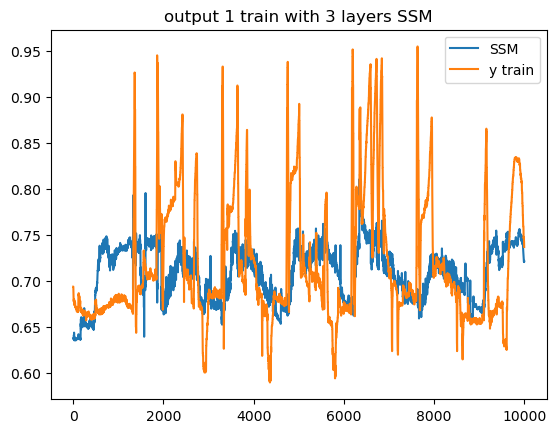

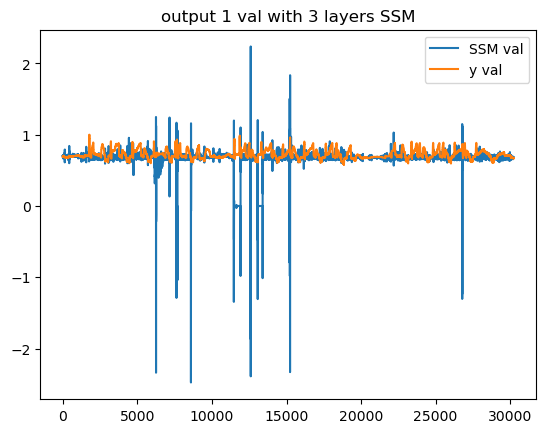

In [19]:
# Plot output 1 for training data
plt.figure('9')
plt.plot(y_pred[0, 10000:20000, 0].detach().numpy(), label='SSM')
plt.plot(y[0, 10000:20000, 0].detach().numpy(), label='y train')
plt.title(f"output 1 train with {n_layers} layers SSM")
plt.legend()
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(ySSM_val[0, 10:, 0].detach().numpy(), label='SSM val')
plt.plot(yval[0, 10:, 0].detach().numpy(), label='y val')
plt.title(f"output 1 val with {n_layers} layers SSM")
plt.legend()
plt.show()


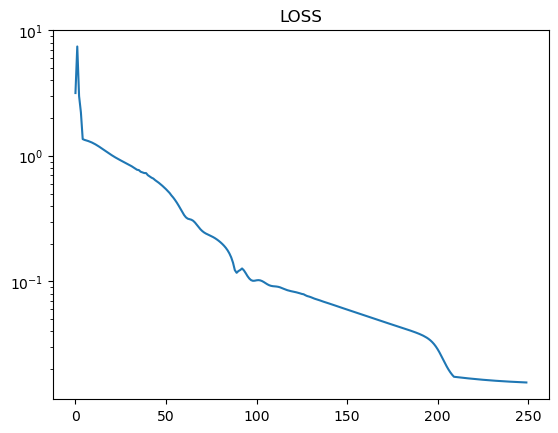

c:\Users\adela\anaconda3\envs\sysid\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\adela\anaconda3\envs\sysid\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


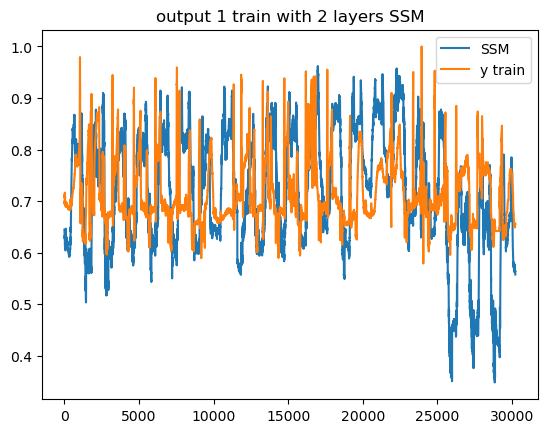

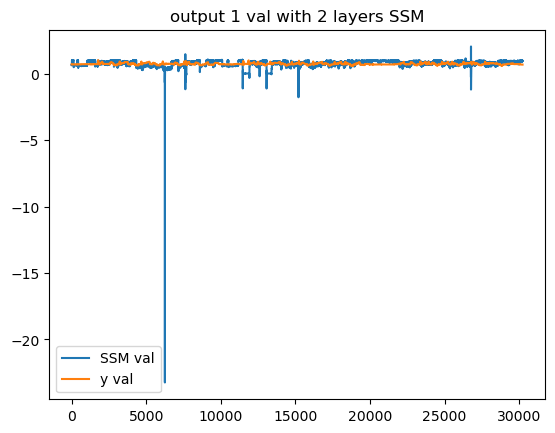

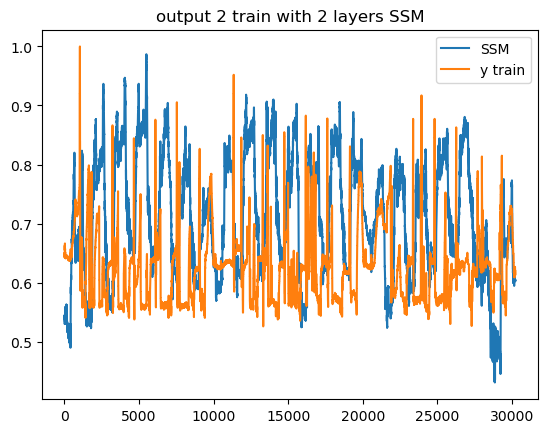

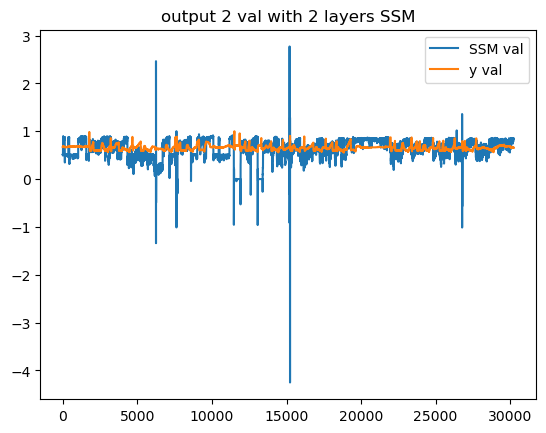

Loss Validation single RNN: 0.05859698727726936


In [7]:
# Plot loss over epochs
plt.figure('8')
plt.plot(LOSS)
plt.yscale('log')
plt.title("LOSS")
plt.show()

# Plot output 1 for training data
plt.figure('9')
plt.plot(y_pred[0, 10:, 0].detach().numpy(), label='SSM')
plt.plot(y[0, 10:, 0].detach().numpy(), label='y train')
plt.title(f"output 1 train with {n_layers} layers SSM")
plt.legend()
plt.show()

# Plot output 1 for validation data
plt.figure('10')
plt.plot(ySSM_val[0, 10:, 0].detach().numpy(), label='SSM val')
plt.plot(yval[0, 10:, 0].detach().numpy(), label='y val')
plt.title(f"output 1 val with {n_layers} layers SSM")
plt.legend()
plt.show()

# Plot output 2 for training data
plt.figure('11')
plt.plot(y_pred[0, 10:, 1].detach().numpy(), label='SSM')
plt.plot(y[0, 10:, 1].detach().numpy(), label='y train')
plt.title(f"output 2 train with {n_layers} layers SSM")
plt.legend()
plt.show()

# Plot output 2 for validation data
plt.figure('12')
plt.plot(ySSM_val[0, 10:, 1].detach().numpy(), label='SSM val')
plt.plot(yval[0, 10:, 1].detach().numpy(), label='y val')
plt.title(f"output 2 val with {n_layers} layers SSM")
plt.legend()
plt.show()

# Save RNN output and validation data to file
#scipy.io.savemat('data_singleRNN_sysID.mat', dict(yRENm_val=yRNN_val.detach().numpy(), yval=yval.detach().numpy()))

# Print validation loss
print(f"Loss Validation single RNN: {loss_val}")